# Limpieza inicial de datos - Proyecto dashboard ESG

Este notebook contiene el proceso de limpieza de las tablas extraídas desde Supabase.

**Autora:** Daniela Artica 

**Rol:** Data Analyst 

**Objetivo:** Documentar y ejecutar los procesos de limpieza, estandarización y tratamiento de valores atípicos (outliers) aplicados a las tablas fuente (finanzas, gobernanza, RRHH, ambiental, dim_tiempo y objetivos) para la construcción de los indicadores ESG y el dashboard de sostenibilidad.

### Importación de librerías y carga de datasets

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# creación de dataframes
df_finanzas = pd.read_csv('../datos sin procesar/fact_finanzas.csv')
df_ambiental = pd.read_csv('../datos sin procesar/fact_ambiental.csv')
df_rrhh = pd.read_csv('../datos sin procesar/fact_rrhh.csv')
df_gobernanza = pd.read_csv('../datos sin procesar/fact_gobernanza_trimestral.csv')
df_objetivos = pd.read_csv('../datos sin procesar/objetivos_esg.csv')
df_tiempo = pd.read_csv('../datos sin procesar/dim_tiempo.csv')

### Exploración inicial

In [3]:
# creación de función para revisar información básica de los dataframes
def revisar_info(df, nombre=""):
    print(f"\n===== INFO: {nombre} =====")
    display(df.head())
    print(df.info())
    print(df.describe(include="all"))

**Exploración de la tabla de hechos de tiempo**

In [4]:
revisar_info(df_tiempo, "DIM TIEMPO")


===== INFO: DIM TIEMPO =====


,id_fecha,fecha,anio,trimestre,mes,mes_nombre,dia_semana_nombre
0,20230101,2023-01-01,2023,1,1,January,Sunday
1,20230102,2023-01-02,2023,1,1,January,Monday
2,20230103,2023-01-03,2023,1,1,January,Tuesday
3,20230104,2023-01-04,2023,1,1,January,Wednesday
4,20230105,2023-01-05,2023,1,1,January,Thursday


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id_fecha           1096 non-null   int64 
 1   fecha              1096 non-null   object
 2   anio               1096 non-null   int64 
 3   trimestre          1096 non-null   int64 
 4   mes                1096 non-null   int64 
 5   mes_nombre         1096 non-null   object
 6   dia_semana_nombre  1096 non-null   object
dtypes: int64(4), object(3)
memory usage: 60.1+ KB
None
            id_fecha       fecha         anio    trimestre          mes  \
count   1.096000e+03        1096  1096.000000  1096.000000  1096.000000   
unique           NaN        1096          NaN          NaN          NaN   
top              NaN  2023-01-01          NaN          NaN          NaN   
freq             NaN           1          NaN          NaN          NaN   
mean    2.024067e+07         NaN  2024.0

En general, la tabla de tiempo se ve consistente y bien estructurada. Sin embargo, se debe convertir la columna fecha a tipo datetime y verificar si faltan días en la secuencia de tiempo

**Exploración de la tabla de hechos de finanzas**

In [5]:
# exploración inicial del dataframe de finanzas
revisar_info(df_finanzas, "FINANZAS")


===== INFO: FINANZAS =====


,id_finanza,id_fecha,ingresos,costos
0,1,20230101,29943.33,6469.15
1,2,20230102,35294.95,6067.79
2,3,20230103,30298.97,14521.33
3,4,20230104,26270.68,14190.64
4,5,20230105,34838.21,23723.44


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1106 entries, 0 to 1105
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id_finanza  1106 non-null   int64  
 1   id_fecha    1106 non-null   int64  
 2   ingresos    1075 non-null   float64
 3   costos      1106 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 34.7 KB
None
        id_finanza      id_fecha      ingresos        costos
count  1106.000000  1.106000e+03  1.075000e+03   1106.000000
mean    553.500000  2.024069e+07  5.851421e+04  15201.595651
std     319.419004  8.168884e+03  5.262851e+05   5771.831504
min       1.000000  2.023010e+07  1.001322e+04   5030.600000
25%     277.250000  2.023100e+07  2.073043e+04  10164.735000
50%     553.500000  2.024070e+07  3.138203e+04  15408.705000
75%     829.750000  2.025040e+07  4.052218e+04  20355.290000
max    1106.000000  2.025123e+07  9.999999e+06  24979.530000


La tabla de finanzas también parece estar bien estructurada. En los datasets que tengan una columna id_fecha, estas se mantendrán como int64 para mantener la relación con dim_tiempo, que también usa el mismo id_fecha entero como llave primaria. A su vez se creará un columna auxiliar convertida a fecha real en los datasets pertinentes para el proceso de limpieza y hacer un análisis exploratorio posterior. 

**Exploración inicial de la tabla de hechos ambiental**

In [6]:
revisar_info(df_ambiental, "AMBIENTAL")


===== INFO: AMBIENTAL =====


,id_ambiental,id_fecha,consumo_kwh,consumo_agua_litros,residuos_totales_kg,residuos_reciclados_kg,huella_carbono_tCO2e
0,1,20230101,2043.87,1492.81,170.63,104.03,942.01
1,2,20230102,2935.51,539.64,129.65,34.41,1364.93
2,3,20230103,1503.57,747.79,87.25,36.91,697.20
3,4,20230104,1654.78,1019.76,140.09,17.45,757.60
4,5,20230105,2155.98,1297.32,166.49,58.80,988.56


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id_ambiental            1096 non-null   int64  
 1   id_fecha                1096 non-null   int64  
 2   consumo_kwh             1096 non-null   float64
 3   consumo_agua_litros     1071 non-null   float64
 4   residuos_totales_kg     1096 non-null   float64
 5   residuos_reciclados_kg  1096 non-null   float64
 6   huella_carbono_tCO2e    1086 non-null   float64
dtypes: float64(5), int64(2)
memory usage: 60.1 KB
None
       id_ambiental      id_fecha  consumo_kwh  consumo_agua_litros  \
count   1096.000000  1.096000e+03  1096.000000          1071.000000   
mean     548.500000  2.024067e+07  2017.527491           983.645023   
std      316.532252  8.172262e+03   588.307810           294.745169   
min        1.000000  2.023010e+07  1000.010000           502.440000   
25%   

Se pueden observar datos nulos en las columnas de consumo de agua y huella de carbono. Asimismo, se debe verificar si faltan días en la secuencia de tiempo, si existen filas duplicadas y si hay datos atípicos en las métricas 

**Exploración inicial de la tabla de hechos de recursos humanos**

In [7]:
revisar_info(df_rrhh, "RRHH")


===== INFO: RRHH =====


,id_rrhh,id_fecha,total_empleados,empleados_nuevos,empleados_baja,liderazgo_femenino,liderazgo_masculino,satisfaccion_empleados
0,1,20230101,42,1,0,11,8,8.4
1,2,20230102,45,2,1,6,11,6.6
2,3,20230103,55,0,0,12,7,7.3
3,4,20230104,56,0,0,7,8,7.7
4,5,20230105,41,1,1,10,8,7.7


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1111 entries, 0 to 1110
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id_rrhh                 1111 non-null   int64  
 1   id_fecha                1111 non-null   int64  
 2   total_empleados         1111 non-null   int64  
 3   empleados_nuevos        1111 non-null   int64  
 4   empleados_baja          1111 non-null   int64  
 5   liderazgo_femenino      1111 non-null   int64  
 6   liderazgo_masculino     1111 non-null   int64  
 7   satisfaccion_empleados  1080 non-null   float64
dtypes: float64(1), int64(7)
memory usage: 69.6 KB
None
          id_rrhh      id_fecha  total_empleados  empleados_nuevos  \
count  1111.00000  1.111000e+03      1111.000000       1111.000000   
mean    556.00000  2.024061e+07        49.153015          1.011701   
std     320.86238  8.150485e+03         5.855004          0.820266   
min       1.00000  2.023010e

Se pueden observar datos nulos en las columnas de satisfacción de empleados. Asimismo, se debe verificar si faltan días en la secuencia de tiempo, si existen filas duplicadas y si hay datos atípicos en las métricas 

**Exploración inicial de la tabla de hechos de gobernanza**

In [8]:
revisar_info(df_gobernanza, "GOBERNANZA")


===== INFO: GOBERNANZA =====


,id_gobernanza,id_fecha,pct_capacitacion_etica,nro_auditorias_internas,canal_denuncias_activo
0,1,20230331,73.7,1,0
1,2,20230630,84.9,1,0
2,3,20230930,80.7,2,0
3,4,20231231,83.2,1,1
4,5,20240331,79.0,2,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id_gobernanza            12 non-null     int64  
 1   id_fecha                 12 non-null     int64  
 2   pct_capacitacion_etica   10 non-null     float64
 3   nro_auditorias_internas  12 non-null     int64  
 4   canal_denuncias_activo   12 non-null     int64  
dtypes: float64(1), int64(4)
memory usage: 612.0 bytes
None
       id_gobernanza      id_fecha  pct_capacitacion_etica  \
count      12.000000  1.200000e+01               10.000000   
mean        6.500000  2.024078e+07               82.840000   
std         3.605551  8.535221e+03                6.878178   
min         1.000000  2.023033e+07               73.700000   
25%         3.750000  2.023116e+07               79.150000   
50%         6.500000  2.024078e+07               81.950000   
75%         9.250000  2.02

Se pueden observar datos nulos en la columna de porcentaje de capacitación ética. Asimismo, se puede ver que los registros de la tabla de gobernanza son trimestrales por lo que se debe verificar que la granularidad esté correcta y que no falten trimestres o hayan registros duplicados.

**Exploración inicial de tabla de objetivos**

In [9]:
revisar_info(df_objetivos, "OBJETIVOS ESG")


===== INFO: OBJETIVOS ESG =====


,id_objetivo,categoria_esg,kpi_nombre,descripcion_objetivo,unidad_medida,valor_objetivo,anio_objetivo,valor_ejemplo
0,1,Ambiental,Tasa Reciclaje,% residuos reciclados,%,0.30,2023,0.250
1,2,Ambiental,Huella Carbono,Toneladas CO2e promedio diario,tCO2e,20.00,2023,21.310
2,3,Social,Rotación,Tasa de rotación anual máxima,%,0.15,2023,0.003
3,4,Social,Equidad,Mujeres en liderazgo,Cantidad,8.00,2023,6.000
4,5,Gobernanza,Capacitación Ética,Porcentaje empleados capacitados,%,80.00,2023,75.803


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id_objetivo           18 non-null     int64  
 1   categoria_esg         18 non-null     object 
 2   kpi_nombre            18 non-null     object 
 3   descripcion_objetivo  18 non-null     object 
 4   unidad_medida         18 non-null     object 
 5   valor_objetivo        18 non-null     float64
 6   anio_objetivo         18 non-null     int64  
 7   valor_ejemplo         18 non-null     float64
dtypes: float64(2), int64(2), object(4)
memory usage: 1.3+ KB
None
        id_objetivo categoria_esg      kpi_nombre   descripcion_objetivo  \
count     18.000000            18              18                     18   
unique          NaN             4               6                     11   
top             NaN     Ambiental  Tasa Reciclaje  % residuos reciclados   
freq            N

La tabla de objetivos está bien estructurada, no existen valores nulos y los objetivos son medibles con las tablas de hechos. Sin embargo, se deberían revisar duplicados y verificar que las unidades estén estandarizadas.

#### Estandarización de tipos de datos

**Tabla tiempo**

In [10]:
df_tiempo['fecha'] = pd.to_datetime(df_tiempo['fecha'], format='%Y-%m-%d')

#### Detección de días faltantes

**Tabla de tiempo**

In [11]:
# creación de un rango de fechas completo y comparación con las fechas existentes
rango = pd.date_range(df_tiempo['fecha'].min(), df_tiempo['fecha'].max(), freq="D")
faltantes = rango.difference(df_tiempo['fecha'])

faltantes

DatetimeIndex([], dtype='datetime64[ns]', freq='D')

No existen días faltantes en la secuencia de tiempo

In [12]:
# creación de columna auxiliar de fecha en dataframes que contienen id_fecha
def agregar_columna_fecha(df):
    if 'id_fecha' in df.columns:
        df['fecha'] = pd.to_datetime(df['id_fecha'].astype(str), format="%Y%m%d")
        # mover la columna al final
        df = df[[col for col in df.columns if col != 'fecha'] + ['fecha']]
    return df


In [13]:
df_finanzas = agregar_columna_fecha(df_finanzas)
df_ambiental = agregar_columna_fecha(df_ambiental)
df_rrhh = agregar_columna_fecha(df_rrhh)
df_gobernanza = agregar_columna_fecha(df_gobernanza)

In [14]:
# creación de función para detectar días faltantes
def detectar_dias_faltantes(df_fact, df_tiempo):
    """
    Detecta días que están en dim_tiempo pero NO en el dataset fact.
    Retorna un DataFrame con los días faltantes.
    """
    # validar que tengan la columna id_fecha
    if 'id_fecha' not in df_fact.columns:
        print("El dataset no contiene id_fecha. No se puede validar días faltantes.")
        return None
    
    # convertir a set para comparar
    fechas_fact = set(df_fact['id_fecha'])
    fechas_completas = set(df_tiempo['id_fecha'])

    # días presentes en dim_tiempo pero NO en el fact
    faltantes = sorted(list(fechas_completas - fechas_fact))

    # devolver un dataframe para visualizarlo
    return pd.DataFrame({'id_fecha_faltante': faltantes})

In [15]:
dias_faltantes_finanzas = detectar_dias_faltantes(df_finanzas, df_tiempo)
dias_faltantes_ambiental = detectar_dias_faltantes(df_ambiental, df_tiempo)
dias_faltantes_rrhh = detectar_dias_faltantes(df_rrhh, df_tiempo)

In [16]:
dias_faltantes_finanzas


,id_fecha_faltante


In [17]:
dias_faltantes_ambiental

,id_fecha_faltante


In [18]:
dias_faltantes_rrhh

,id_fecha_faltante


La tablas de finanzas, recursos humanos y ambiental están completas y son consistentes con el dataframe dim_tiempo.

In [19]:
# identificación de días faltantes en gobernanza trimestral
# creación de columnas auxiliares de año y trimestre
df_gobernanza['anio'] = df_gobernanza['fecha'].dt.year
df_gobernanza['trimestre'] = df_gobernanza['fecha'].dt.quarter
df_gobernanza.head()

,id_gobernanza,id_fecha,pct_capacitacion_etica,nro_auditorias_internas,canal_denuncias_activo,fecha,anio,trimestre
0,1,20230331,73.7,1,0,2023-03-31,2023,1
1,2,20230630,84.9,1,0,2023-06-30,2023,2
2,3,20230930,80.7,2,0,2023-09-30,2023,3
3,4,20231231,83.2,1,1,2023-12-31,2023,4
4,5,20240331,79.0,2,1,2024-03-31,2024,1


In [20]:
# ver cuántos registros hay por año y trimestre
df_gobernanza.groupby(['anio', 'trimestre']).size()

anio  trimestre
2023  1            1
      2            1
      3            1
      4            1
2024  1            1
      2            1
      3            1
      4            1
2025  1            1
      2            1
      3            1
      4            1
dtype: int64

Se puede ver que no hay trimestres faltantes, por lo que los registros son consistentes con la tabla de tiempo 

## Detección de duplicados

### Identificar filas completamente duplicadas

In [21]:
# creación de función para detectar filas duplicadas
def contar_duplicados(df):
    return df.duplicated().sum()

In [22]:
print("Duplicados finanzas:", contar_duplicados(df_finanzas))
print("Duplicados ambiental:", contar_duplicados(df_ambiental))
print("Duplicados rrhh:", contar_duplicados(df_rrhh))
print("Duplicados gobernanza:", contar_duplicados(df_gobernanza)) 
print("Duplicados objetivos esg:", contar_duplicados(df_objetivos))  

Duplicados finanzas: 0
Duplicados ambiental: 0
Duplicados rrhh: 0
Duplicados gobernanza: 0
Duplicados objetivos esg: 0


No existen filas duplicadas en ninguno de los dataframes

### Identificar filas duplicadas por id_fecha

In [ ]:
# Crear una serie booleana que marca todas las filas que tienen un 'id_fecha' repetido.
filas_duplicadas = df_finanzas.duplicated(subset=['id_fecha'], keep=False)

# Filtrar el DataFrame original para mostrar solo esas filas
df_duplicados_finanzas = df_finanzas[filas_duplicadas]

# Ordenar por 'id_fecha' para ver los pares de duplicados agrupados
df_duplicados_finanzas = df_duplicados_finanzas.sort_values(by='id_fecha')

# Mostrar los resultados
print("--- Registros Duplicados Encontrados ---")
print(f"Total de filas que participan en duplicados: {len(df_duplicados_finanzas)}")
print(df_duplicados_finanzas)

--- Registros Duplicados Encontrados ---
Total de filas que participan en duplicados: 20
      id_finanza  id_fecha  ingresos    costos      fecha
168          169  20230618  47464.12   9495.83 2023-06-18
1098        1099  20230618  47464.12   9495.83 2023-06-18
1105        1106  20231112  16911.59  19069.04 2023-11-12
315          316  20231112  16911.59  19069.04 2023-11-12
1097        1098  20240113  38381.89  23832.74 2024-01-13
377          378  20240113  38381.89  23832.74 2024-01-13
1103        1104  20240206  22018.00   5601.78 2024-02-06
401          402  20240206  22018.00   5601.78 2024-02-06
1102        1103  20240506       NaN  22240.67 2024-05-06
491          492  20240506       NaN  22240.67 2024-05-06
1096        1097  20241025  14484.71  10743.11 2024-10-25
663          664  20241025  14484.71  10743.11 2024-10-25
904          905  20250623  38006.95   8323.51 2025-06-23
1101        1102  20250623  38006.95   8323.51 2025-06-23
1100        1101  20250707  40216.55   78

Se puede notar que las columnas de ingresos y costos tienen los mismos valores, por lo que se optará por eliminar los duplicados conservando el primer registro

In [24]:
# Eliminación de duplicados conservando la primera instancia
df_finanzas = df_finanzas.drop_duplicates(subset=['id_fecha'], keep='first')

# Verificar
print(f"Total de filas después de la limpieza: {len(df_finanzas)}")

Total de filas después de la limpieza: 1096


In [ ]:
# Crear una serie booleana que marca todas las filas que tienen un 'id_fecha' repetido.

filas_duplicadas = df_rrhh.duplicated(subset=['id_fecha'], keep=False)

# Filtrar el DataFrame original para mostrar solo esas filas
df_duplicados_rrhh = df_rrhh[filas_duplicadas]

# Ordenar por 'id_fecha' para ver los pares de duplicados agrupados
df_duplicados_rrhh = df_duplicados_rrhh.sort_values(by='id_fecha')

# Mostrar los resultados
print("--- Registros Duplicados Encontrados ---")
print(f"Total de filas que participan en duplicados: {len(df_duplicados_rrhh)}")
print(df_duplicados_rrhh)

--- Registros Duplicados Encontrados ---
Total de filas que participan en duplicados: 30
      id_rrhh  id_fecha  total_empleados  empleados_nuevos  empleados_baja  \
10         11  20230111               44                 0               1   
1099     1100  20230111               44                 0               1   
61         62  20230303               46                 2               0   
1103     1104  20230303               46                 2               0   
67         68  20230309               40                 2               0   
1097     1098  20230309               40                 2               0   
252       253  20230910               44                 2               0   
1105     1106  20230910               44                 2               0   
261       262  20230919               44                 1               0   
1102     1103  20230919               44                 1               0   
1104     1105  20231016               42             

De manera similar a la tabla de finanzas, en la tabla de recursos humanos también existen registros duplciados con los mismo valores en columnas como total_empleados, empleados_nuevos y empleados_baja. Se eliminarán dichos registros conservando la primera instancia.

In [26]:
# Eliminación de duplicados conservando la primera instancia
df_rrhh = df_rrhh.drop_duplicates(subset=['id_fecha'], keep='first')

# Verificar
print(f"Total de filas después de la limpieza: {len(df_rrhh)}")

Total de filas después de la limpieza: 1096


#### Corrección de datos nulos

In [27]:
# creación de función para contar valores nulos por columna
def contar_nulos(df):
    return df.isnull().sum()

**Corrección de datos nulos para la tabla de finanzas**

In [28]:
contar_nulos(df_finanzas)

id_finanza     0
id_fecha       0
ingresos      30
costos         0
fecha          0
dtype: int64

El dataset de finanzas contiene 31 registros nulos en la columna de ingresos. Sin embargo, la columna costos tiene todos los registros completos, lo cual indica que sí hubo actividad operativa en esos días. Por ello, se imputarán los valores nulos con 0, asumiendo que cada día en el que se registró un valor nulo representa un día en el que no hubo ingresos   


In [29]:
df_finanzas['ingresos'] = df_finanzas['ingresos'].fillna(0)

In [30]:
# Confirmar que no quedaron nulos
print("Nulos post-imputación:")
print(df_finanzas.isna().sum())

Nulos post-imputación:
id_finanza    0
id_fecha      0
ingresos      0
costos        0
fecha         0
dtype: int64


**Corrección de datos nulos para la tabla ambiental**

In [31]:
contar_nulos(df_ambiental)

id_ambiental               0
id_fecha                   0
consumo_kwh                0
consumo_agua_litros       25
residuos_totales_kg        0
residuos_reciclados_kg     0
huella_carbono_tCO2e      10
fecha                      0
dtype: int64

Existen 25 registros nulos en la columna consumo_agua_litros y 10 registros nulos en la columna huella_carbono_tco2e. 

In [32]:
# identificar dónde están los valores nulos en el dataframe ambiental
nulos_agua = df_ambiental[df_ambiental['consumo_agua_litros'].isna()]
nulos_carbono = df_ambiental[df_ambiental['huella_carbono_tCO2e'].isna()]

print("Nulos en consumo_agua_litros:")
display(nulos_agua[['id_fecha', 'consumo_agua_litros']].head(10))

print("\nNulos en huella_carbono_tCO2e:")
display(nulos_carbono[['id_fecha', 'huella_carbono_tCO2e']].head(10))

Nulos en consumo_agua_litros:


,id_fecha,consumo_agua_litros
74,20230316,NaN
80,20230322,NaN
129,20230510,NaN
143,20230524,NaN
144,20230525,NaN
283,20231011,NaN
307,20231104,NaN
333,20231130,NaN
358,20231225,NaN
498,20240513,NaN



Nulos en huella_carbono_tCO2e:


,id_fecha,huella_carbono_tCO2e
75,20230317,NaN
111,20230422,NaN
227,20230816,NaN
400,20240205,NaN
495,20240510,NaN
605,20240828,NaN
772,20250211,NaN
985,20250912,NaN
1051,20251117,NaN
1067,20251203,NaN


In [33]:
print("Distribución de nulos por mes:")
df_ambiental['mes'] = df_ambiental['fecha'].dt.month
print(df_ambiental[df_ambiental['consumo_agua_litros'].isna()]['mes'].value_counts())

Distribución de nulos por mes:
mes
5     5
10    4
11    3
6     3
3     2
12    2
9     2
8     2
1     1
2     1
Name: count, dtype: int64


In [34]:
print(df_ambiental[df_ambiental['huella_carbono_tCO2e'].isna()]['mes'].value_counts())

mes
8     2
2     2
3     1
4     1
5     1
9     1
11    1
12    1
Name: count, dtype: int64


Como los valores nulos están distribuidos de forma aislada dentro de una serie temporal diaria, eliminarlos generaría pérdida innecesaria de datos.

Por ello se aplicará la interpolación lineal basada en la fecha, que permite completar los valores manteniendo la tendencia natural del consumo y las emisiones, sin introducir saltos artificiales. Este método es adecuado para series temporales y preserva la coherencia para el análisis y la construcción de KPIs ambientales.

In [35]:
# Asegurar orden correcto
df_ambiental = df_ambiental.sort_values('fecha')

# Interpolación lineal solo para columnas numéricas con nulos
df_ambiental['consumo_agua_litros'] = df_ambiental['consumo_agua_litros'].interpolate(method='linear')
df_ambiental['huella_carbono_tCO2e'] = df_ambiental['huella_carbono_tCO2e'].interpolate(method='linear')

# Verificar si aún quedan nulos
print(df_ambiental[['consumo_agua_litros', 'huella_carbono_tCO2e']].isna().sum())

consumo_agua_litros     0
huella_carbono_tCO2e    0
dtype: int64


**Corrección de datos nulos en la tabla de recursos humanos**

In [36]:
contar_nulos(df_rrhh)

id_rrhh                    0
id_fecha                   0
total_empleados            0
empleados_nuevos           0
empleados_baja             0
liderazgo_femenino         0
liderazgo_masculino        0
satisfaccion_empleados    30
fecha                      0
dtype: int64

Existen 30 valores nulos en la columna de satisfaccion_empleados

In [37]:
# identificar dónde están los valores nulos en el dataframe rrhh
nulos_satisfaccion = df_rrhh[df_rrhh['satisfaccion_empleados'].isna()]


print("Nulos en satisfaccion_empleados:")
display(nulos_satisfaccion[['fecha', 'satisfaccion_empleados']].head(10))

Nulos en satisfaccion_empleados:


,fecha,satisfaccion_empleados
46,2023-02-16,NaN
56,2023-02-26,NaN
60,2023-03-02,NaN
283,2023-10-11,NaN
296,2023-10-24,NaN
299,2023-10-27,NaN
311,2023-11-08,NaN
347,2023-12-14,NaN
381,2024-01-17,NaN
402,2024-02-07,NaN


In [38]:
print("Distribución de nulos por mes:")
df_rrhh['mes'] = df_rrhh['fecha'].dt.month
print(df_rrhh[df_rrhh['satisfaccion_empleados'].isna()]['mes'].value_counts())

Distribución de nulos por mes:
mes
10    4
2     3
3     3
11    3
12    3
5     3
8     3
7     2
6     2
9     2
1     1
4     1
Name: count, dtype: int64


 Los valores nulos están distribuidos de forma aislada a lo largo del tiempo. Como la satisfacción de los empleados se trata de un indicador continuo y estable, la interpolación temporal mantiene la coherencia de la serie sin distorsionar tendencias. Por ello, se aplicará df.interpolate(method='time') para completar los valores faltantes.

In [39]:
# Asegurar que 'fecha' es datetime y está como índice temporal
df_rrhh['fecha'] = pd.to_datetime(df_rrhh['fecha'])
df_rrhh = df_rrhh.sort_values('fecha').set_index('fecha')

# Interpolación temporal
df_rrhh['satisfaccion_empleados'] = df_rrhh['satisfaccion_empleados'].interpolate(method='time')

In [40]:
# Volver al formato original
df_rrhh = df_rrhh.reset_index()

In [41]:
# Verificar si aún quedan nulos
print(df_rrhh[['satisfaccion_empleados']].isna().sum())

satisfaccion_empleados    0
dtype: int64


**Corrección de datos nulos en la tabla de gobernanza**

In [42]:
contar_nulos(df_gobernanza)

id_gobernanza              0
id_fecha                   0
pct_capacitacion_etica     2
nro_auditorias_internas    0
canal_denuncias_activo     0
fecha                      0
anio                       0
trimestre                  0
dtype: int64

In [43]:
df_gobernanza.head(12)

,id_gobernanza,id_fecha,pct_capacitacion_etica,nro_auditorias_internas,canal_denuncias_activo,fecha,anio,trimestre
0,1,20230331,73.7,1,0,2023-03-31,2023,1
1,2,20230630,84.9,1,0,2023-06-30,2023,2
2,3,20230930,80.7,2,0,2023-09-30,2023,3
3,4,20231231,83.2,1,1,2023-12-31,2023,4
4,5,20240331,79.0,2,1,2024-03-31,2024,1
5,6,20240630,83.5,1,0,2024-06-30,2024,2
6,7,20240930,93.2,2,0,2024-09-30,2024,3
7,8,20241231,NaN,2,1,2024-12-31,2024,4
8,9,20250331,79.6,1,0,2025-03-31,2025,1
9,10,20250630,75.6,2,0,2025-06-30,2025,2


En la tabla de gobernanza se identificaron valores nulos en Q4-2024 y Q3-2025 en la columna pct_capacitacion_etica. Dado que se trata de una serie trimestral con periodos faltantes, se aplicará la interpolación lineal entre los valores conocidos más cercanos, evitando la interpolación temporal que asumiría continuidad en periodos no reportados.

In [44]:
# ordenar por id_fecha
df_gobernanza = df_gobernanza.sort_values('id_fecha')

df_gobernanza['pct_capacitacion_etica'] = (
    df_gobernanza['pct_capacitacion_etica']
    .interpolate(method='linear')
)

# Verificar si aún quedan nulos
print(df_gobernanza[['pct_capacitacion_etica']].isna().sum())

pct_capacitacion_etica    0
dtype: int64


#### Validación de valores correctos

In [45]:
# Costos o ingresos negativos no deberían existir
neg_ing = df_finanzas[df_finanzas['ingresos'] < 0]
neg_costos = df_finanzas[df_finanzas['costos'] < 0]

print("Ingresos negativos:", len(neg_ing))
print("Costos negativos:", len(neg_costos))

Ingresos negativos: 0
Costos negativos: 0


## Detección de outliers

Para la detección de valores atípicos se utilizará el método IQR, complementado con visualizaciones de histogramas y boxplots

### Detección de outliers en la tabla de finanzas

In [46]:
# Función para detectar outliers por IQR
def detect_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lim_inf = Q1 - 1.5 * IQR
    lim_sup = Q3 + 1.5 * IQR
    return series[(series < lim_inf) | (series > lim_sup)]


In [47]:
# detección de outliers en ingresos
outliers_ingresos = detect_outliers_iqr(df_finanzas['ingresos'])
print("Outliers en ingresos:")
display(df_finanzas.loc[outliers_ingresos.index])

Outliers en ingresos:


,id_finanza,id_fecha,ingresos,costos,fecha
50,51,20230220,9999999.0,17188.15,2023-02-20
546,547,20240630,9999999.0,20224.10,2024-06-30
679,680,20241110,9999999.0,16214.93,2024-11-10


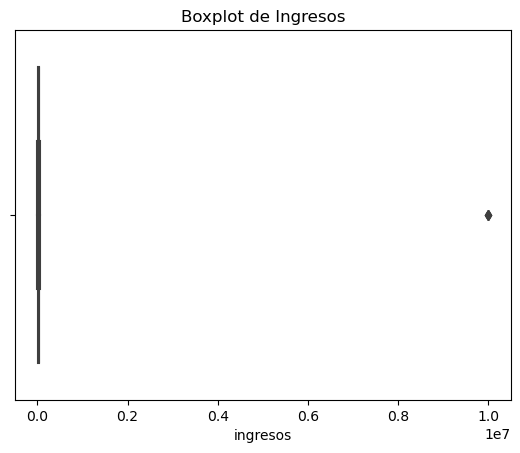

In [48]:
sns.boxplot(x=df_finanzas['ingresos'])
plt.title("Boxplot de Ingresos")
plt.show()

In [49]:
# detección de outliers en costos
outliers_costos = detect_outliers_iqr(df_finanzas['costos'])
print("Outliers en costos:")
display(df_finanzas.loc[outliers_costos.index])

Outliers en costos:


,id_finanza,id_fecha,ingresos,costos,fecha


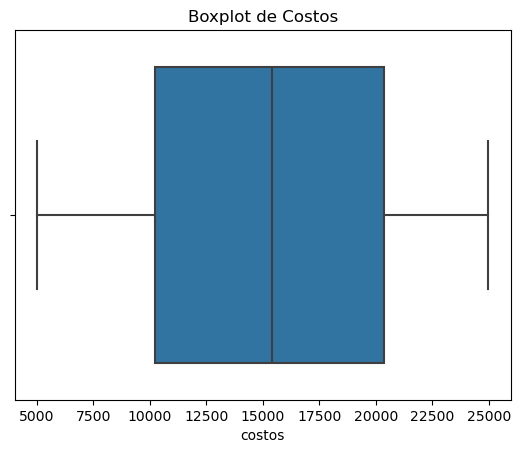

In [50]:
sns.boxplot(x=df_finanzas['costos'])
plt.title("Boxplot de Costos")
plt.show()

In [51]:
df_finanzas[df_finanzas['ingresos'] == 9999999.0]

,id_finanza,id_fecha,ingresos,costos,fecha
50,51,20230220,9999999.0,17188.15,2023-02-20
546,547,20240630,9999999.0,20224.10,2024-06-30
679,680,20241110,9999999.0,16214.93,2024-11-10


Se encontraron 3 valores atípicos de 9,999,999 en la columna de ingresos posiblemente debido a errores de aleatorización o carga. Dado que los datos atípicos representan una pequeña cantidad (0.3%) de todo el dataset y con la finalidad de garantizar la precisión de las métricas financieras, se procederá a eliminar dichos registros. 

In [52]:
# eliminación de outliers en ingresos
# definición del valor atípico a eliminar
valor_atipico = 9999999

# guardar la cantidad original de registros para verificación
registros_originales = len(df_finanzas)

# crear un nuevo DataFrame que excluya las filas con el valor atípico en 'ingresos'
df_finanzas_limpio = df_finanzas[df_finanzas['ingresos'] != valor_atipico].copy()

# verificación de la limpieza
registros_limpios = len(df_finanzas_limpio)
registros_eliminados = registros_originales - registros_limpios

print(f" Limpieza de Outliers Terminada.")
print(f"   - Registros originales: {registros_originales}")
print(f"   - Registros eliminados (por {valor_atipico}): {registros_eliminados}")
print(f"   - Nuevo total de registros: {registros_limpios}")

 Limpieza de Outliers Terminada.
   - Registros originales: 1096
   - Registros eliminados (por 9999999): 3
   - Nuevo total de registros: 1093


### Detección de outliers en la tabla ambiental

In [53]:
df_ambiental.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id_ambiental            1096 non-null   int64         
 1   id_fecha                1096 non-null   int64         
 2   consumo_kwh             1096 non-null   float64       
 3   consumo_agua_litros     1096 non-null   float64       
 4   residuos_totales_kg     1096 non-null   float64       
 5   residuos_reciclados_kg  1096 non-null   float64       
 6   huella_carbono_tCO2e    1096 non-null   float64       
 7   fecha                   1096 non-null   datetime64[ns]
 8   mes                     1096 non-null   int32         
dtypes: datetime64[ns](1), float64(5), int32(1), int64(2)
memory usage: 72.9 KB


In [54]:
# detección de outliers en la columna de consumo_kwh
outliers_consumo_kwh = detect_outliers_iqr(df_ambiental['consumo_kwh'])
print("Outliers en consumo kwh:")
display(df_ambiental.loc[outliers_consumo_kwh.index])

Outliers en consumo kwh:


,id_ambiental,id_fecha,consumo_kwh,consumo_agua_litros,residuos_totales_kg,residuos_reciclados_kg,huella_carbono_tCO2e,fecha,mes


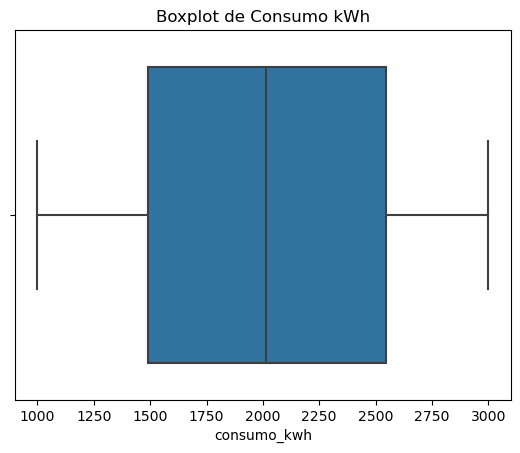

In [55]:
sns.boxplot(x=df_ambiental['consumo_kwh'])
plt.title("Boxplot de Consumo kWh")
plt.show()  

No existen valores atípicos en la columna de consumo_kwh

In [56]:
# detección de outliers en la columna de consumo_agua_litros
outliers_consumo_agua = detect_outliers_iqr(df_ambiental['consumo_agua_litros'])
print("Outliers en consumo agua litros:")
display(df_ambiental.loc[outliers_consumo_agua.index])

Outliers en consumo agua litros:


,id_ambiental,id_fecha,consumo_kwh,consumo_agua_litros,residuos_totales_kg,residuos_reciclados_kg,huella_carbono_tCO2e,fecha,mes


In [57]:
# detección de outliers en la columna de residuos_totales_kg
outliers_residuos_totales = detect_outliers_iqr(df_ambiental['residuos_totales_kg'])
print("Outliers en residuos totales kg:")
display(df_ambiental.loc[outliers_residuos_totales.index])

Outliers en residuos totales kg:


,id_ambiental,id_fecha,consumo_kwh,consumo_agua_litros,residuos_totales_kg,residuos_reciclados_kg,huella_carbono_tCO2e,fecha,mes


In [58]:
# detección de outliers en la columna de residuos_reciclados_kg
outliers_residuos_reciclados = detect_outliers_iqr(df_ambiental['residuos_reciclados_kg'])
print("Outliers en residuos reciclados kg:")
display(df_ambiental.loc[outliers_residuos_reciclados.index])

Outliers en residuos reciclados kg:


,id_ambiental,id_fecha,consumo_kwh,consumo_agua_litros,residuos_totales_kg,residuos_reciclados_kg,huella_carbono_tCO2e,fecha,mes
107,108,20230418,1133.5,811.73,195.64,136.77,531.76,2023-04-18,4


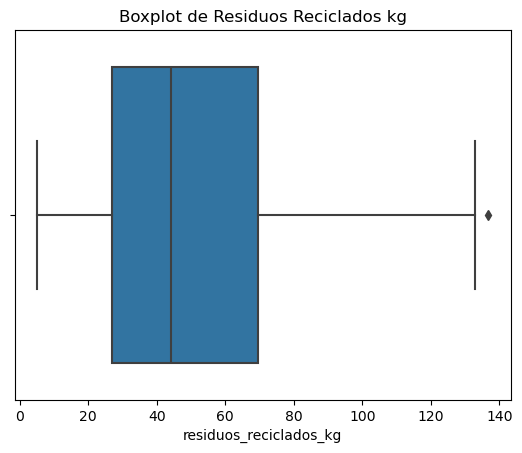

In [59]:
sns.boxplot(x=df_ambiental['residuos_reciclados_kg'])
plt.title("Boxplot de Residuos Reciclados kg")
plt.show()  

Se encontró un valor atípico en la columna residuos_reciclados_kg con un valor de 136.77. Dado que este registro solo representa el 0.09% del total de datos, se optará por eliminarlo.

In [ ]:
# eliminación de outliers en la tabla ambiental
# definición del valor atípico a eliminar
valor_atipico = 136.77

# guardar la cantidad original de registros para verificación
registros_originales = len(df_ambiental)

# crear un nuevo DataFrame que excluya las filas con el valor atípico en 'residuos_reciclados_kg'
df_ambiental_limpio = df_ambiental[df_ambiental['residuos_reciclados_kg'] != valor_atipico].copy()

# verificación de la limpieza
registros_limpios = len(df_ambiental_limpio)
registros_eliminados = registros_originales - registros_limpios

print(f" Limpieza de Outliers Terminada.")
print(f"   - Registros originales: {registros_originales}")
print(f"   - Registros eliminados (por {valor_atipico}): {registros_eliminados}")
print(f"   - Nuevo total de registros: {registros_limpios}")

 Mediana limpia de residuos_reciclados_kg: 44.11


In [62]:
# detección de outliers en la columna de huella_carbono_tCO2e
outliers_huella_carbono = detect_outliers_iqr(df_ambiental_imputado['huella_carbono_tCO2e'])
print("Outliers en huella de carbono tCO2e:")
display(df_ambiental_imputado.loc[outliers_huella_carbono.index])

Outliers en huella de carbono tCO2e:


,id_ambiental,id_fecha,consumo_kwh,consumo_agua_litros,residuos_totales_kg,residuos_reciclados_kg,huella_carbono_tCO2e,fecha,mes


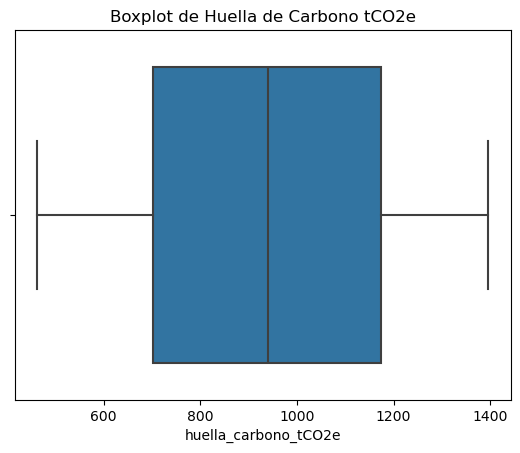

In [63]:
sns.boxplot(x=df_ambiental_imputado['huella_carbono_tCO2e'])
plt.title("Boxplot de Huella de Carbono tCO2e")
plt.show()

No existen valores atípicos en la columna de huella de carbono

### Detección de outliers en la tabla de recursos humanos

In [64]:
df_rrhh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   fecha                   1096 non-null   datetime64[ns]
 1   id_rrhh                 1096 non-null   int64         
 2   id_fecha                1096 non-null   int64         
 3   total_empleados         1096 non-null   int64         
 4   empleados_nuevos        1096 non-null   int64         
 5   empleados_baja          1096 non-null   int64         
 6   liderazgo_femenino      1096 non-null   int64         
 7   liderazgo_masculino     1096 non-null   int64         
 8   satisfaccion_empleados  1096 non-null   float64       
 9   mes                     1096 non-null   int32         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(7)
memory usage: 81.5 KB


In [65]:
# detección de outliers en la columna de total_empleados
outliers_total_empleados = detect_outliers_iqr(df_rrhh['total_empleados'])
print("Outliers en total empleados:")
display(df_rrhh.loc[outliers_total_empleados.index])

Outliers en total empleados:


,fecha,id_rrhh,id_fecha,total_empleados,empleados_nuevos,empleados_baja,liderazgo_femenino,liderazgo_masculino,satisfaccion_empleados,mes


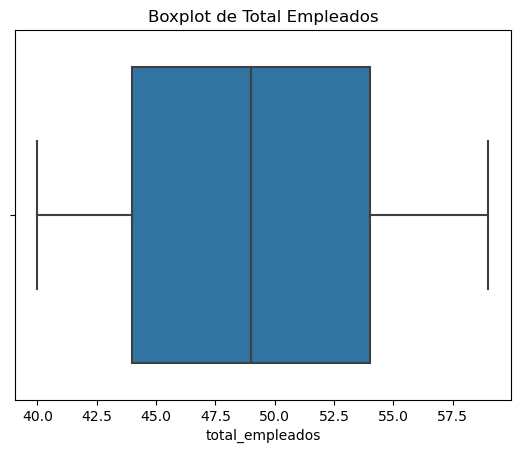

In [66]:
sns.boxplot(x=df_rrhh['total_empleados'])
plt.title("Boxplot de Total Empleados")
plt.show()  

No existen valores atípicos en la columna de total_empleados.

In [67]:
# detección de outliers en la columna de empleados_nuevos
outliers_empleados_nuevos = detect_outliers_iqr(df_rrhh['empleados_nuevos'])
print("Outliers en empleados nuevos:")
display(df_rrhh.loc[outliers_empleados_nuevos.index])

Outliers en empleados nuevos:


,fecha,id_rrhh,id_fecha,total_empleados,empleados_nuevos,empleados_baja,liderazgo_femenino,liderazgo_masculino,satisfaccion_empleados,mes


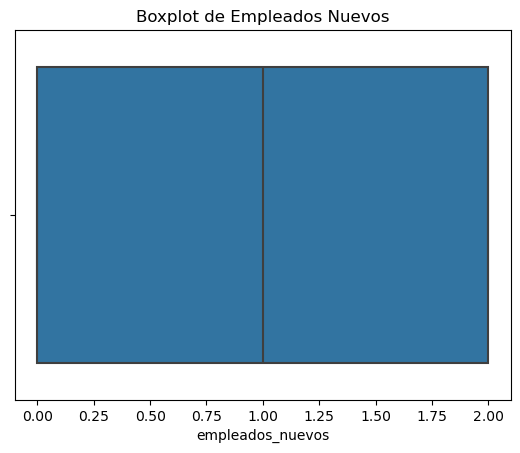

In [68]:
sns.boxplot(x=df_rrhh['empleados_nuevos'])
plt.title("Boxplot de Empleados Nuevos")
plt.show()  

No existen valores atípicos en la columna de empleados nuevos. De hecho se puede ver que contiene valores enteros muy limitados, entre 0 y 2, lo cual va de acuerdo con la cantidad de nuevos empleados contratados en una micro o pequeña empresa. En lugar de tratarla como una variable continua, se debería analizar esta variable usando métricas de frecuencia o moda.

In [69]:
# detección de outliers en la columna de empleados_baja
outliers_empleados_baja = detect_outliers_iqr(df_rrhh['empleados_baja'])
print("Outliers en empleados baja:")
display(df_rrhh.loc[outliers_empleados_baja.index])

Outliers en empleados baja:


,fecha,id_rrhh,id_fecha,total_empleados,empleados_nuevos,empleados_baja,liderazgo_femenino,liderazgo_masculino,satisfaccion_empleados,mes


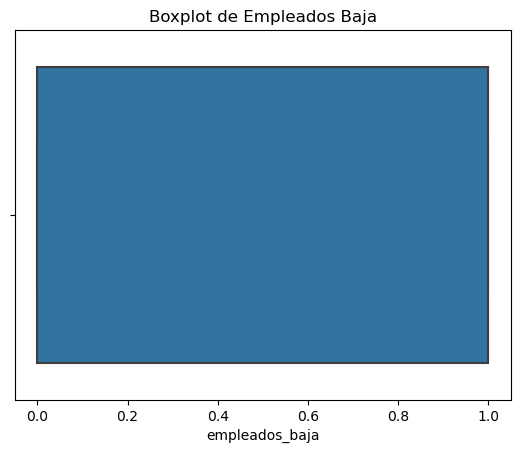

In [70]:
sns.boxplot(x=df_rrhh['empleados_baja'])
plt.title("Boxplot de Empleados Baja")
plt.show()      

In [71]:
df_rrhh['empleados_baja'].describe()

count    1096.000000
mean        0.511861
std         0.500087
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: empleados_baja, dtype: float64

In [72]:
df_rrhh['empleados_baja'].value_counts()

empleados_baja
1    561
0    535
Name: count, dtype: int64

Similar a la columna empleados_nuevos, no existen valores atípicos en esta columna. Además, el rango de valores enteros que contiene es bastante limitado, entre 0 y 1. Se puede notar que casi la mitad de los días (51,2%) la empresa tiene una sola baja y la otra mitad de los días (48,8%) no tiene ninguna baja, lo cual anticipa una estabilidad en la rotación de personal.

In [73]:
# detección de outliers en la columna de liderazgo_femenino
outliers_liderazgo_femenino = detect_outliers_iqr(df_rrhh['liderazgo_femenino'])
print("Outliers en liderazgo femenino:")
display(df_rrhh.loc[outliers_liderazgo_femenino.index])

Outliers en liderazgo femenino:


,fecha,id_rrhh,id_fecha,total_empleados,empleados_nuevos,empleados_baja,liderazgo_femenino,liderazgo_masculino,satisfaccion_empleados,mes


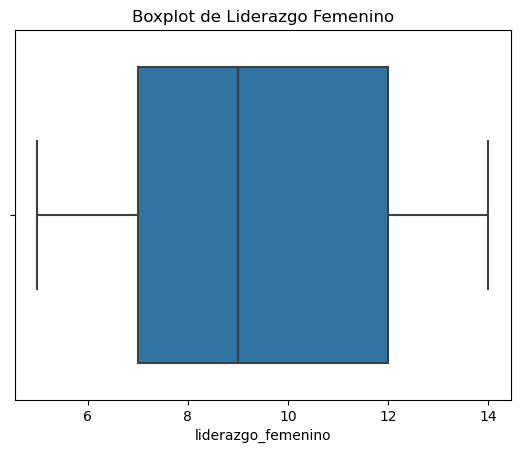

In [74]:
sns.boxplot(x=df_rrhh['liderazgo_femenino'])
plt.title("Boxplot de Liderazgo Femenino")
plt.show()

Se puede notar que no existen valores atípicos en la distribución de la columna de liderazgo femenino y los valores oscilan entre 5 y 14 mujeres en puestos de liderazgo en la empresa a lo largo de 3 años de registros.

In [75]:
# detección de outliers en la columna de liderazgo_masculino
outliers_liderazgo_masculino = detect_outliers_iqr(df_rrhh['liderazgo_masculino'])
print("Outliers en liderazgo masculino:")
display(df_rrhh.loc[outliers_liderazgo_masculino.index])

Outliers en liderazgo masculino:


,fecha,id_rrhh,id_fecha,total_empleados,empleados_nuevos,empleados_baja,liderazgo_femenino,liderazgo_masculino,satisfaccion_empleados,mes


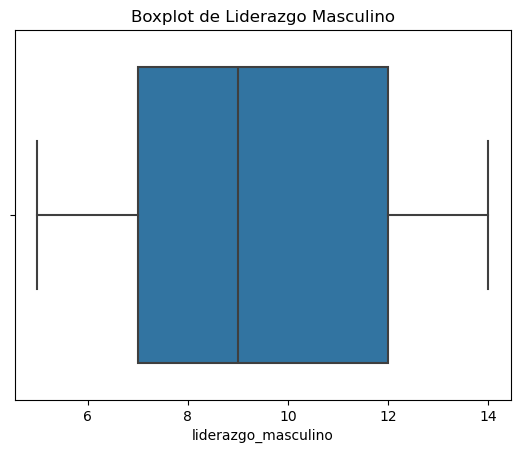

In [76]:
sns.boxplot(x=df_rrhh['liderazgo_masculino'])
plt.title("Boxplot de Liderazgo Masculino")
plt.show()

De manera similar a la columna de liderazgo femenino, no existen valores atípicos en la columna de liderazgo masculino y los valores se oscilan entre 5 y 14 hombres en puestos liderazgo dentro de la empresa. 

In [77]:
# detección de outliers en la columna de satisfaccion_empleados
outliers_satisfaccion_empleados = detect_outliers_iqr(df_rrhh['satisfaccion_empleados'])
print("Outliers en satisfacción de empleados:")
display(df_rrhh.loc[outliers_satisfaccion_empleados.index])

Outliers en satisfacción de empleados:


,fecha,id_rrhh,id_fecha,total_empleados,empleados_nuevos,empleados_baja,liderazgo_femenino,liderazgo_masculino,satisfaccion_empleados,mes


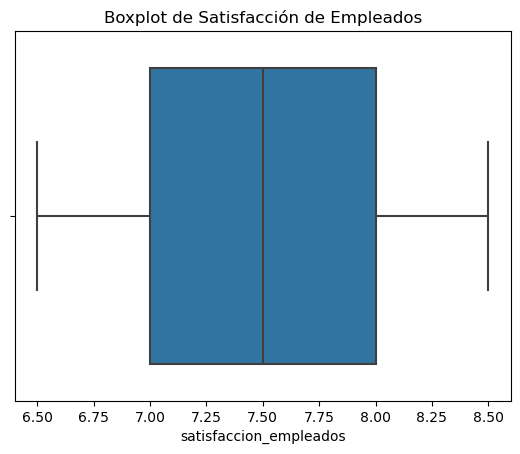

In [78]:
sns.boxplot(x=df_rrhh['satisfaccion_empleados'])
plt.title("Boxplot de Satisfacción de Empleados")
plt.show()

No se encontraron valores atípicos en la columna de satisfacción de empleados y se puede ver que los valores oscilan entre 6.5 y 8.5, lo cual anticipa una satisfacción de los empleados moderada en la empresa

### Detección de outliers en la tabla de gobernanza

In [79]:
df_gobernanza.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id_gobernanza            12 non-null     int64         
 1   id_fecha                 12 non-null     int64         
 2   pct_capacitacion_etica   12 non-null     float64       
 3   nro_auditorias_internas  12 non-null     int64         
 4   canal_denuncias_activo   12 non-null     int64         
 5   fecha                    12 non-null     datetime64[ns]
 6   anio                     12 non-null     int32         
 7   trimestre                12 non-null     int32         
dtypes: datetime64[ns](1), float64(1), int32(2), int64(4)
memory usage: 804.0 bytes


In [80]:
# detección de outliers en la columna de pct_capacitacion_etica
outliers_pct_capacitacion_etica = detect_outliers_iqr(df_gobernanza['pct_capacitacion_etica'])
print("Outliers en porcentaje de capacitación en ética:")
display(df_gobernanza.loc[outliers_pct_capacitacion_etica.index])

Outliers en porcentaje de capacitación en ética:


,id_gobernanza,id_fecha,pct_capacitacion_etica,nro_auditorias_internas,canal_denuncias_activo,fecha,anio,trimestre
11,12,20251231,95.0,2,1,2025-12-31,2025,4


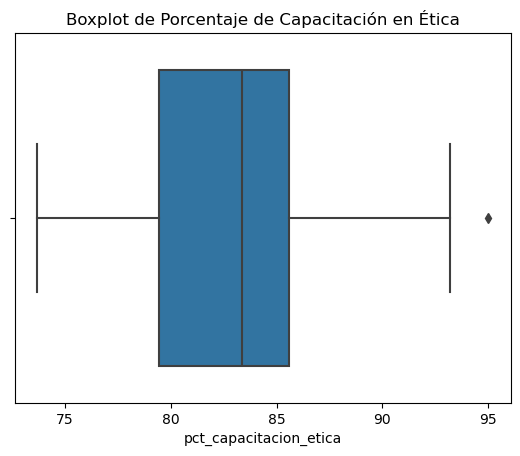

In [81]:
sns.boxplot(x=df_gobernanza['pct_capacitacion_etica'])
plt.title("Boxplot de Porcentaje de Capacitación en Ética")
plt.show()  

Se encontró un valor atípico de 95% en el porcentaje de capacitación ética. Sin embargo, dado que los registros solo abarcan 12 trimestres se evaluará si es que ese valor atípico es un error comparado con el resto de valores.

In [82]:
df_gobernanza['pct_capacitacion_etica'].describe()

count    12.000000
mean     83.341667
std       6.335249
min      73.700000
25%      79.450000
50%      83.350000
75%      85.575000
max      95.000000
Name: pct_capacitacion_etica, dtype: float64

In [83]:
df_gobernanza['pct_capacitacion_etica'].value_counts()

pct_capacitacion_etica
73.7    1
84.9    1
80.7    1
83.2    1
79.0    1
83.5    1
93.2    1
86.4    1
79.6    1
75.6    1
85.3    1
95.0    1
Name: count, dtype: int64

In [84]:
# Cálculo de la media excluyendo el valor atípico identificado
# Definir la columna y el valor atípico a excluir
columna = 'pct_capacitacion_etica'
valor_atipico = 95.0

# Crear una máscara (filtro) para excluir el valor atípico

mascara_limpia = df_gobernanza[columna] != valor_atipico

# Aplicar la máscara y calcular la media

media_limpia = df_gobernanza[columna][mascara_limpia].mean()

# Mostrar el resultado y la verificación
registros_total = len(df_gobernanza)
registros_limpios = len(df_gobernanza[columna][mascara_limpia])

print(f" Columna analizada: {columna}")
print(f"   - Registros originales: {registros_total}")
print(f"   - Registros usados para la media: {registros_limpios}")
print(f" La Media excluyendo {valor_atipico} es: {media_limpia:.4f}")


 Columna analizada: pct_capacitacion_etica
   - Registros originales: 12
   - Registros usados para la media: 11
 La Media excluyendo 95.0 es: 82.2818


Se puede ver que la diferencia entre la media original (83.30) y la media sin el outlier (82.28) es mínima (solo 1.02 puntos porcentuales), lo cual no afectaría significativamente los KPI de gobernanza. Además, el valor de 95.0 está muy cerca de los valores más altos de la serie como 93.2, por lo que no es un valor que rompa la escala y puede ser posible. Por ello, se mantendrá dicho valor con la finalidad de mantener la integridad de la serie temporal de 12 trimestres y evitar introducir valores artificiales. 

In [85]:

# detección de outliers en la columna de nro_auditorias_internas
outliers_nro_auditorias_internas = detect_outliers_iqr(df_gobernanza['nro_auditorias_internas'])
print("Outliers en número de auditorías internas:")
display(df_gobernanza.loc[outliers_nro_auditorias_internas.index]) 

Outliers en número de auditorías internas:


,id_gobernanza,id_fecha,pct_capacitacion_etica,nro_auditorias_internas,canal_denuncias_activo,fecha,anio,trimestre


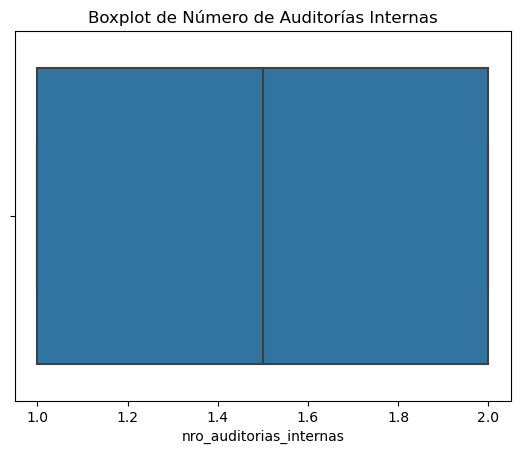

In [86]:
sns.boxplot(x=df_gobernanza['nro_auditorias_internas'])
plt.title("Boxplot de Número de Auditorías Internas")
plt.show()

In [87]:
df_gobernanza['nro_auditorias_internas'].describe()

count    12.000000
mean      1.500000
std       0.522233
min       1.000000
25%       1.000000
50%       1.500000
75%       2.000000
max       2.000000
Name: nro_auditorias_internas, dtype: float64

In [88]:
df_gobernanza['nro_auditorias_internas'].value_counts()

nro_auditorias_internas
1    6
2    6
Name: count, dtype: int64

Se puede ver que no existen valores atípicos en la columna de número de auditorías internas y que la mitad de los trimestres se hizo una auditoría interna y la otra mitad de los trimestres se hicieron 2 auditorías. 

## Evaluación de coherencia y estandarización de texto en la tabla de objetivos

In [89]:
print("--- Categoria ESG ---")
print(df_objetivos['categoria_esg'].value_counts())


--- Categoria ESG ---
categoria_esg
Ambiental     6
Social        6
Gobernanza    3
Financiero    3
Name: count, dtype: int64


In [90]:
print("\n--- Nombre del KPI ---")
print(df_objetivos['kpi_nombre'].value_counts())


--- Nombre del KPI ---
kpi_nombre
Tasa Reciclaje        3
Huella Carbono        3
Rotación              3
Equidad               3
Capacitación Ética    3
Margen Neto           3
Name: count, dtype: int64


In [91]:
print("\n--- Unidad de Medida ---")
print(df_objetivos['unidad_medida'].value_counts())


--- Unidad de Medida ---
unidad_medida
%           12
tCO2e        3
Cantidad     3
Name: count, dtype: int64


Los datos en la tabla de objetivos ya están estandarizados y listos para ser usados

## Eliminación de columnas auxiliares

In [92]:
# eliminación de columna innecesaria
df_objetivos = df_objetivos.drop(columns=['valor_ejemplo'])

La columna valor_ejemplo fue eliminada debido a que no representa datos reales medidos ni objetivos oficiales, sino valores referenciales que podrían generar confusión en el análisis.

In [93]:
df_finanzas_limpio = df_finanzas_limpio.drop(columns=['fecha'])

In [ ]:
df_ambiental_limpio = df_ambiental_limpio.drop(columns=['mes','fecha'])
df_ambiental_limpio

,id_ambiental,id_fecha,consumo_kwh,consumo_agua_litros,residuos_totales_kg,residuos_reciclados_kg,huella_carbono_tCO2e
0,1,20230101,2043.87,1492.81,170.63,104.03,942.01
1,2,20230102,2935.51,539.64,129.65,34.41,1364.93
2,3,20230103,1503.57,747.79,87.25,36.91,697.20
3,4,20230104,1654.78,1019.76,140.09,17.45,757.60
4,5,20230105,2155.98,1297.32,166.49,58.80,988.56
...,...,...,...,...,...,...,...
1091,1092,20251227,1679.38,874.34,96.04,41.13,784.13
1092,1093,20251228,2137.71,1478.17,104.08,27.27,983.89
1093,1094,20251229,1147.99,1344.30,73.98,42.65,531.25
1094,1095,20251230,2231.43,775.14,82.23,43.98,1020.05


In [95]:
df_rrhh = df_rrhh.drop(columns=['mes','fecha'])

In [96]:
df_gobernanza = df_gobernanza.drop(columns=['anio','trimestre','fecha'])   

In [97]:
df_tiempo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id_fecha           1096 non-null   int64         
 1   fecha              1096 non-null   datetime64[ns]
 2   anio               1096 non-null   int64         
 3   trimestre          1096 non-null   int64         
 4   mes                1096 non-null   int64         
 5   mes_nombre         1096 non-null   object        
 6   dia_semana_nombre  1096 non-null   object        
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 60.1+ KB


In [98]:
df_finanzas_limpio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1093 entries, 0 to 1095
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id_finanza  1093 non-null   int64  
 1   id_fecha    1093 non-null   int64  
 2   ingresos    1093 non-null   float64
 3   costos      1093 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 42.7 KB


In [99]:
df_gobernanza.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id_gobernanza            12 non-null     int64  
 1   id_fecha                 12 non-null     int64  
 2   pct_capacitacion_etica   12 non-null     float64
 3   nro_auditorias_internas  12 non-null     int64  
 4   canal_denuncias_activo   12 non-null     int64  
dtypes: float64(1), int64(4)
memory usage: 612.0 bytes


In [100]:
df_ambiental_imputado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id_ambiental            1096 non-null   int64  
 1   id_fecha                1096 non-null   int64  
 2   consumo_kwh             1096 non-null   float64
 3   consumo_agua_litros     1096 non-null   float64
 4   residuos_totales_kg     1096 non-null   float64
 5   residuos_reciclados_kg  1096 non-null   float64
 6   huella_carbono_tCO2e    1096 non-null   float64
dtypes: float64(5), int64(2)
memory usage: 60.1 KB


In [101]:
df_rrhh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id_rrhh                 1096 non-null   int64  
 1   id_fecha                1096 non-null   int64  
 2   total_empleados         1096 non-null   int64  
 3   empleados_nuevos        1096 non-null   int64  
 4   empleados_baja          1096 non-null   int64  
 5   liderazgo_femenino      1096 non-null   int64  
 6   liderazgo_masculino     1096 non-null   int64  
 7   satisfaccion_empleados  1096 non-null   float64
dtypes: float64(1), int64(7)
memory usage: 68.6 KB


In [102]:
df_objetivos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id_objetivo           18 non-null     int64  
 1   categoria_esg         18 non-null     object 
 2   kpi_nombre            18 non-null     object 
 3   descripcion_objetivo  18 non-null     object 
 4   unidad_medida         18 non-null     object 
 5   valor_objetivo        18 non-null     float64
 6   anio_objetivo         18 non-null     int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 1.1+ KB


In [103]:
# estandarización de nombres de dataframes limpios
df_ambiental_limpio = df_ambiental_imputado.copy()
df_rrhh_limpio = df_rrhh.copy()
df_gobernanza_limpio = df_gobernanza.copy()
df_objetivos_limpio = df_objetivos.copy()
df_tiempo_limpio = df_tiempo.copy()

In [104]:
print(type(df_ambiental_limpio))
print(type(df_finanzas_limpio))
print(type(df_rrhh_limpio))
print(type(df_gobernanza_limpio))
print(type(df_tiempo_limpio))
print(type(df_objetivos_limpio))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


## Exportación de archivos csv

In [105]:
df_ambiental_limpio.to_csv('../datos limpios/ambiental_limpio.csv', index=False)
df_finanzas_limpio.to_csv('../datos limpios/finanzas_limpio.csv', index=False)
df_rrhh_limpio.to_csv('../datos limpios/rrhh_limpio.csv', index=False)
df_gobernanza_limpio.to_csv('../datos limpios/gobernanza_limpio.csv', index=False)
df_tiempo_limpio.to_csv('../datos limpios/tiempo_limpio.csv', index=False)
df_objetivos_limpio.to_csv('../datos limpios/objetivos_limpio.csv', index=False)